## This notebook is used for simulating the real world inland shipping emissions

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools

# package(s) related to the simulation
import simpy
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph 
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages



### create graph with navigation info

In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.4492,0],
    [1.1678,0], 
    [1.6619,0]  
] 

# for each edge (between above coordinates) specify the depth [m] and current speed [m/s]
depths = [6, 4.5, 3.5]

current_speeds = [-0.75,
                  -1.25,
                  -1.5]  # [m/s]


V_g_profile_up = [1,1,1] # [m/s], ship velocity over ground for upstream, if this is not used, set to'none' in vessel data dictionary below

V_g_profile_down = [3,3,3] # [m/s], ship velocity over ground for downstream

# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):

    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile_upstream": V_g_profile_up[index],
        "VesselSpeedToGroundProfile_downstream": V_g_profile_down[index]
    })

FG = FG.to_undirected() 
FG = FG.to_directed() 

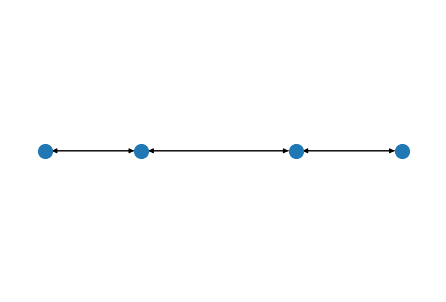

In [4]:
# show graph
nx.draw(FG, positions, node_size=200)

plt.show()

In [5]:
#  Note that edges are made bi-directional for upstream and downstream  
for edge in FG.edges:
    print('General depth for edge {} is {} m'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))
    print('Current speed for edge {} is {} m/s'.format(edge, -FG.get_edge_data(edge[0], edge[1])["Info"]["CurrentSpeed"]))
    print('Vessel Speed To Ground for edge {} is {} m/s while sailing upstream'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["VesselSpeedToGroundProfile_upstream"]))
    print('Vessel Speed To Ground for edge {} is {} m/s while sailing downstream'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["VesselSpeedToGroundProfile_downstream"]))

General depth for edge ('Node 0', 'Node 1') is 6 m
Current speed for edge ('Node 0', 'Node 1') is 0.75 m/s
Vessel Speed To Ground for edge ('Node 0', 'Node 1') is 1 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 0', 'Node 1') is 3 m/s while sailing downstream
General depth for edge ('Node 1', 'Node 0') is 6 m
Current speed for edge ('Node 1', 'Node 0') is 0.75 m/s
Vessel Speed To Ground for edge ('Node 1', 'Node 0') is 1 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 1', 'Node 0') is 3 m/s while sailing downstream
General depth for edge ('Node 1', 'Node 2') is 4.5 m
Current speed for edge ('Node 1', 'Node 2') is 1.25 m/s
Vessel Speed To Ground for edge ('Node 1', 'Node 2') is 1 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 1', 'Node 2') is 3 m/s while sailing downstream
General depth for edge ('Node 2', 'Node 1') is 4.5 m
Current speed for edge ('Node 2', 'Node 1') is 1.25 m/s
Vessel Speed To Ground for edge ('Node 2', 'Node 1')

### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [7]:
# Create a dict with all important settings

data_vessel_up = {
    "env": None,
    "name": 'Vessel M6',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":4.4,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "H_e": None, 
    "H_f": None, 
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 780.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 2000,
}             



In [8]:
# Create a dict with all important settings

data_vessel_down = {
    "env": None,
    "name": 'Vessel M6',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":4.44,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "H_e": None, 
    "H_f": None, 
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 780.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 2000, # although the construction year of Herso 1 is 1961, checking with the SFC used in the paper,it is similar as year of 2000
}             



### define sailing paths

In [9]:
path_upstream = nx.dijkstra_path(FG, nodes[0].name, nodes[3].name)
path_downstream = nx.dijkstra_path(FG, nodes[3].name, nodes[0].name)

### define simulation "Vessel sailing upstream and downstream"

In [10]:
def run_simulation(path,**data_vessel):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    # vessel.V_g_ave = V_g_ave
    # vessel.sailing_upstream = sailing_upstream
    # vessel.P_tot_given = P_tot_given
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

### run upstream simulation to get emissions results

In [11]:
vessel_upstream = run_simulation(path = path_upstream, **data_vessel_up)
# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_upstream = opentnsim.energy.EnergyCalculation(FG, vessel_upstream)
energycalculation_upstream.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_upstream = pd.DataFrame.from_dict(energycalculation_upstream.energy_use)
selected = ['edge_start','edge_stop',
            'P_tot','P_installed',
            'total_emission_CO2','total_emission_PM10','total_emission_NOX']
df_upstream = df_upstream[selected]
df_upstream

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,P_tot,P_installed,total_emission_CO2,total_emission_PM10,total_emission_NOX
0,POINT (0 0),POINT (0.4492 0),22.602555,780.0,255087.606909,229.814312,5400.636325
1,POINT (0.4492 0),POINT (1.1678 0),49.125877,780.0,879561.561876,730.184533,17472.376669
2,POINT (1.1678 0),POINT (1.6619 0),72.977811,780.0,880679.703406,580.125063,14705.867783


#### upstream emissions

In [12]:
upstream_single_trip_CO2 = (df_upstream['total_emission_CO2']/1000).sum() #kg
upstream_single_trip_PM10 = (df_upstream['total_emission_PM10']/1000).sum() #kg
upstream_single_trip_NOx = (df_upstream['total_emission_NOX']/1000).sum() #kg
upstream_single_trip_emissions = [upstream_single_trip_CO2,upstream_single_trip_PM10,upstream_single_trip_NOx]
upstream_single_trip_emissions = pd.DataFrame(upstream_single_trip_emissions, 
                                               index=['CO2 [kg]','PM10 [kg]','NOx [kg]'],
                                              columns = ['single upstream trip'])
upstream_single_trip_emissions


,single upstream trip
CO2 [kg],2015.328872
PM10 [kg],1.540124
NOx [kg],37.578881


### run downstream simulation to get emissions results

In [13]:
vessel_downstream = run_simulation(path = path_downstream, **data_vessel_down)
# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_downstream = opentnsim.energy.EnergyCalculation(FG, vessel_downstream)
energycalculation_downstream.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_downstream = pd.DataFrame.from_dict(energycalculation_downstream.energy_use)
selected = ['edge_start','edge_stop',
            'P_tot','P_installed',
            'total_emission_CO2','total_emission_PM10','total_emission_NOX']
df_downstream = df_downstream[selected]
df_downstream

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,P_tot,P_installed,total_emission_CO2,total_emission_PM10,total_emission_NOX
0,POINT (1.6619 0),POINT (1.1678 0),16.818947,780.0,69596.032069,62.700671,1473.465777
1,POINT (1.1678 0),POINT (0.4492 0),23.945337,780.0,144104.983478,129.827505,3050.946370
2,POINT (0.4492 0),POINT (0 0),46.281219,780.0,173066.478305,147.135099,3501.862094


#### downstream emissions

In [14]:
downstream_single_trip_CO2 = (df_downstream['total_emission_CO2']/1000).sum() #kg
downstream_single_trip_PM10 = (df_downstream['total_emission_PM10']/1000).sum() #kg
downstream_single_trip_NOx = (df_downstream['total_emission_NOX']/1000).sum() #kg
downstream_single_trip_emissions = [downstream_single_trip_CO2,downstream_single_trip_PM10,downstream_single_trip_NOx]
downstream_single_trip_emissions = pd.DataFrame(downstream_single_trip_emissions, 
                                               index=['CO2 [kg]','PM10 [kg]','NOx [kg]'],
                                               columns = ['single downstream trip'])
downstream_single_trip_emissions


,single downstream trip
CO2 [kg],386.767494
PM10 [kg],0.339663
NOx [kg],8.026274
